In [3]:
from collections import deque 
import networkx as nx

En esta sesión veremos algunos algoritmos o modificaciones de algoritmos que hemos visto que se relacionan con caminos y ciclos en una gráfica.

# Caminos

En un ejercicio de la clase pasada, se vio que con BFS podemos determinar la distancia entre dos vértices. De esto surgen dos preguntas 'naturales':

*   ¿Es posible además de saber la distancia construir un camino de longitud mínima entre dos vértices?
*   ¿Qué pasa si las aristas tienen peso? Es decir, que las aristas tengan un valor asignado, y en lugar de que la longitud de un camino sea el número de aristas, que sea la suma de los valores sobre cada arista del camino.

La primera pregunta la trabajaremos en este notebook, mientras que la segunda requiere de un algoritmo más sofisticado: el algoritmo de Dijkstra, que veremos en otra sesión más adelante.

Recordemos el algoritmo de BFS visto en la clase pasada : 

In [5]:
def bfs(g, v):
    visited = [False] * len(g.nodes)
    q = deque()
    visited[v] = True
    q.append(v)
    
    while(q):
        u = q.popleft()
        print(u) # Pueden hacer lo que quieran
        for w in g.adj[u]:
            if not visited[w]:
                visited[w] = True
                q.append(w)

Aplicándolo a una gráfica:

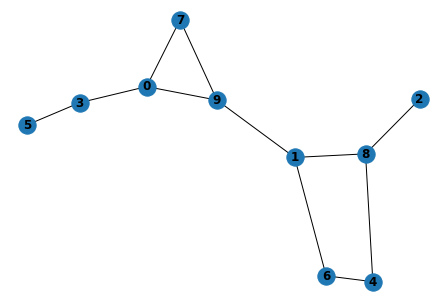

In [25]:
G = nx.gnp_random_graph(10, 1/4)
nx.draw(G, with_labels=True, font_weight='bold')

In [26]:
bfs(G, 0)

0
3
7
9
5
1
6
8
4
2


¿Cómo construir un camino de longitud mínima de $0$ a cualquier otro vértice usando este código? Notemos que podemos hacer algunas ligeras modificaciones para lograr nuestro objetivo : en lugar de que $vis[\;]$ guarde si ya vimmos al vértice o no, crearemos una lista $par[ \; ]$ que guarde al vértice 'padre' de cada vértice que se vaya visitando, es decir, si $u$ es vecino de $v$ y $u$ no ha sido visitado en el recorrido de nuestro BFS, haremos $par[u] = v$, indicando que justo para pasar a $u$ pasamos por $v$ previamente.

Notemos que al tener guardados estos 'padres' de los vértices podemos reconstruir fácilmente un camino de longitud mínima de cualquier $v$ a $0$, pues basta con ir caminando sobre los padres de los vértices, comenzando por $v$, hasta llegar a $0$.

In [28]:
def bfsr(g, v):
    parents = [None] * len(g.nodes)
    q = deque()
    parents[v] = v
    q.append(v)
    
    while(q):
        u = q.popleft()
        for w in g.adj[u]:
            if parents[w] is None:
                parents[w] = u
                q.append(w)
    parents[v] = None #Porque el nodo raiz del arbol
    return parents
    
par = bfsr(G, 0)
for i, p in enumerate(par):
    print(f"{i} es hijo de {p}")

0 es hijo de None
1 es hijo de 9
2 es hijo de 8
3 es hijo de 0
4 es hijo de 6
5 es hijo de 3
6 es hijo de 1
7 es hijo de 0
8 es hijo de 1
9 es hijo de 0


Con esta lista de padres, podemos reconstruir un camino entre cualquier par de vértices:

In [9]:
def path(g, start, end):
    par = bfsr(g, start)
    if par[end] is None: # No están en la misma componente conexa
        return [] 
    else:
        out = [end]
        while par[end] != start:
            end = par[end]
            out.append(end)
        out.append(start)
    return out

path(G, 0, 4)

[]

En otro ejercicio de la clase pasada, vimos que es posible detectar las componentes conexas de nuestra gráfica, y esto es posible usando cualquiera de DFS o BFS.

# Ciclos

¿Cómo detectar si una gráfica tiene algún ciclo? Veamos cómo hacer esto usando DFS, para esto es importante guardar el padre de cada vértice, pues si algún vértice tiene un vértice adyacente que no es su padre y que ya vimos en el recorrido, entonces tenemos un ciclo.

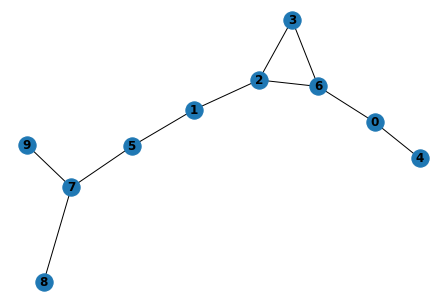

In [29]:
G = nx.gnp_random_graph(10, 1/4)
nx.draw(G, with_labels=True, font_weight='bold')

In [31]:
def dfs_cycle(g, v, parents, cycle=[False]):
    for u in g.adj[v]:
        if parents[u] is None:
            parents[u] = v
            dfs_cycle(g, u, parents, cycle)
        elif parents[v] != u:
            cycle[0] = True
    return cycle[0]


def has_cycle(g):
    """Con que cumpla que existe un ciclo devulve True"""
    parents = [None] * len(g.nodes)
    cycle = False
    for v in g.nodes:   
        if parents[v] is None:
            print(v) # Primera componente conexa.
            parents[v] = v
            cycle = cycle | dfs_cycle(g, v, parents)
    return cycle
            
has_cycle(G)

0


True

# Árboles generadores

El árbol generador de una gráfica $G$ es un árbol que contiene todos los vértices de $G$. Podemos usar DFS (o BFS) para producirlo de la siguiente manera:

1. Caminamos toda la gráfica y obtenemos los padres de cada vértice.
2. Insertamos una arista entre hijo y su padre.

Al árbol resultante se le conoce como árbol DFS (o BFS).

In [12]:
def dfs_parents(g, v, parents=None):
    if parents is None:
        parents = [None] * len(g.nodes)
        parents[v] = v
    for u in g.adj[v]:
        if parents[u] is None:
            parents[u] = v
            dfs_parents(g, u, parents)
    return parents


def dfs_tree(g, v):
    parents = dfs_parents(g, v)
    parents[v] = None

    tree = nx.Graph()
    tree.add_nodes_from(g.nodes)
    for child, par in enumerate(parents):
        if child is not None and par is not None:
            tree.add_edge(child, par)
    return tree

Generamos una gráfica de prueba:

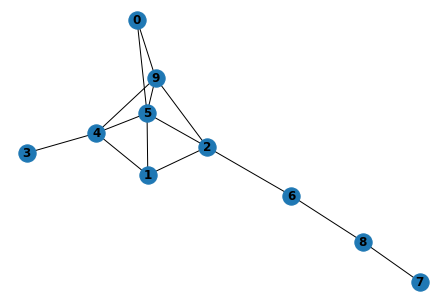

In [13]:
G = nx.gnp_random_graph(10, 1/3)
nx.draw(G, with_labels=True, font_weight='bold')

Y calculamos su árbol DFS:

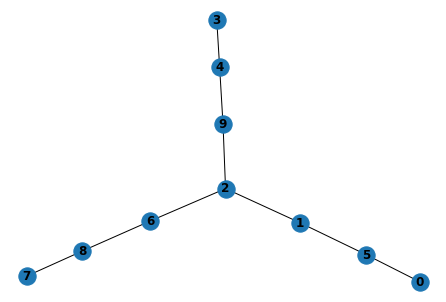

In [14]:
nx.draw(dfs_tree(G, 0), with_labels=True, font_weight='bold')

# Puentes

Dada una gráfica $G$, decimos que una arista $e$ es un puente si al remover $e$ de la gráfica, el número de componentes conexas aumenta. Por ejemplo, en un árbol todas las aristas son puentes, mientras que en un ciclo no hay aristas que sean puentes.

Dado un recorrido de DFS, las aristas de la gráfica original pueden dividirse en dos clases:

*  **Arista de árbol**: Arista que pertenece al árbol DFS, es decir, que pasamos por ella cuando hacemos el recorrido DFS.

*  **Arista trasera**: Arista que no es de árbol.

Adicionalmente, definimos al **sub árbol de DFS con raíz en $v$** como el árbol que se tiene de considerar los vértices que fueron visitados a partir de $v$ en el recorrido de DFS, considerando las respectivas aristas, así como los vértices que ya no se recorrieron por haber sido visitados antes con las aristas respectivas (es decir, los vértices por los que preguntamos si ya habían sido visitados, y que en efecto ya habían sido visitados, por lo que se deja de explorar dicha rama).

Veamos estas definiciones en un ejemplo concreto. En la siguiente gráfica los vértices ya están numerados según un posible recorrido de DFS.

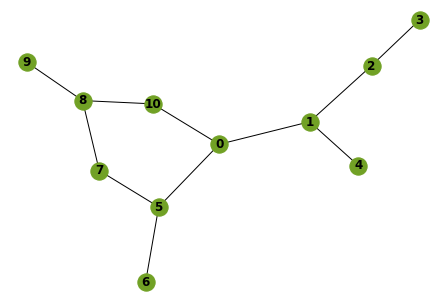

In [15]:
Ex = nx.Graph()

Ex.add_edges_from([(0,1), (0,5), (1,2), (1,4), (2,3), (5,6), (5, 7), (7,8), (8,9), (8, 10), (0, 10)])
nx.draw(Ex, with_labels=True, font_weight='bold', node_color='#71A125')

En el ejemplo anterior, la arista $(5,7)$ es delantera, mientras que la arista $(10, 0)$ es trasera. 

El sub árbol de DFS con raíz en $1$ es el conformado por los vértices $1, 2, 3, 4$, el sub árbol de DFS con raíz en $10$ es el árbol con vértices $0, 10$ y la arista entre ellas, y finalmente, el subárbol de DFS con raíz en $5$ es el conformado por los vértices $5, 6, 7, 8, 9, 10, 0$, con todas las posibles aristas (de la gráfica dada), excepto por la arista $(0, 5)$.

Notemos que una arista trasera siempre pertenece a un ciclo en la gráfica inicial, por lo que no puede ser un puente. De hecho la gráfica tiene ciclos si y solo si tiene aristas traseras, que fue lo que usamos para el algoritmo anterior. Entonces, únicamente las aristas delanteras son candidatas a ser puentes, ¿cómo saber cuáles lo son? Sigamos los siguientes pasos:

1.   Numerar los vértices según su orden de aparición en el recorrido de DFS (tal como se hizo con la gráfica del ejemplo). Sea $num[v]$ el número correspondiente a $v$.
2.   Para cada vértice $v$, guardar el menor valor de entre todos los vértices que pertenecen al sub árbol de DFS con raíz en $v$. Llamaremos a este número $low[v]$.
3.   Para cada arista delantera $(u, v)$, donde $u$ es padre de $v$ en el árbol de DFS (que tiene como raíz al $0$) comprobamos si $num[u] < low[v]$. Sucede que $num[u] < low[v]$ si y solo si la arista $(u, v)$ es puente (¿por qué?).

El siguiente código es una implementación de este algoritmo, nos permitirá encontrar todos los puentes en una gráfica dada.

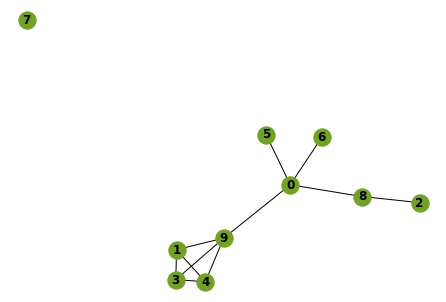

In [16]:
n = 10
p = 0.3
GP = nx.gnp_random_graph(n,p)

nx.draw(GP, with_labels=True, font_weight='bold', node_color='#71A125')

In [17]:
def find_bridges(g, u, num=None, low=None, par=None, bridges=None, current=0):
    if num is None:
        num = [-1] * len(g.nodes)
    if low is None:
        low = [-1] * len(g.nodes)
    if par is None:
        par = [-1] * len(g.nodes)
    if bridges is None:
        bridges = []
        
    low[u] = current
    num[u] = current
    current += 1
    for v in g.adj[u]:
        if v != par[u]:
            if num[v] == -1:
                par[v] = u
                find_bridges(g, v, num, low, par, bridges, current)
            low[u] = min(low[u], low[v])
            if num[u] < low[v]:
                bridges.append((u,v))
    return bridges

bridges = find_bridges(GP, 0)
print(bridges)

#Comparemos nuestro resultado con la función bridges que viene implementada en la librería NetworkX
print(list(nx.bridges(GP)))

[(0, 5), (0, 6), (8, 2), (0, 8), (0, 9)]
[(0, 5), (0, 6), (0, 8), (0, 9), (2, 8)]


# Ejercicios 

Dada una gráfica con vértices numerados del $0$ al $n-1$:

1.   Dentro de la componente conexa que contiene a $u$, encuentra el vértice que se encuentra a mayor distancia de $u$ e imprime un camino entre $u$ y dicho vértice. (Si hay más de uno con que lo hagas para un vértice es suficiente). 
2.   Determina si la componente conexa de $u$ tiene al menos un ciclo, y en caso de que sí tenga, encuentra e imprime dos caminos distintos (sí pueden compartir aristas, pero el conjunto de aristas usadas en cada uno debe ser distinto) que conecten a $u$ con $v$, donde $v$ es el vértice de tu elección.



Para ambos ejercicios, tu código debe trabajar sobre la siguiente gráfica (puedes cambiar los parámetros si gustas).

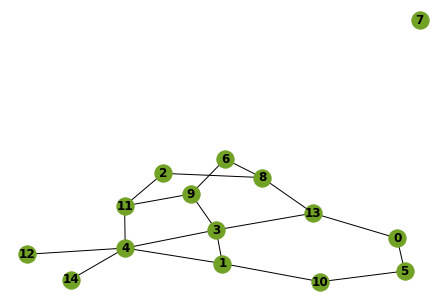

In [4]:
l = 15
q = 0.25
GE = nx.gnp_random_graph(l,q)

nx.draw(GE, with_labels=True, font_weight='bold', node_color='#71A125')


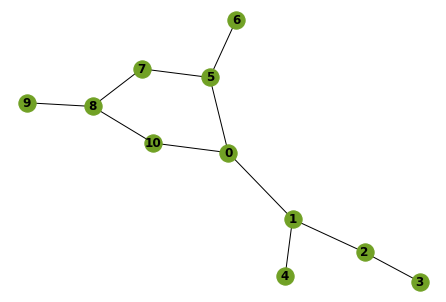

In [9]:
Ex = nx.Graph()

Ex.add_edges_from([(0,1), (0,5), (1,2), (1,4), (2,3), (5,6), (5, 7), (7,8), (8,9), (8, 10), (0, 10)])
nx.draw(Ex, with_labels=True, font_weight='bold', node_color='#71A125')

In [21]:
# path(G, 0, 4)
par, num, low = find_bridges(Ex, 0)
print(par)
for i, p in enumerate(par):
    print(f"{i} es hijo de {p}")
print("----------")
print(num)
print(low)
print("----------")
par = bfsr(Ex, 0)
print(par)
for i, p in enumerate(par):
    print(f"{i} es hijo de {p}")


[-1, 0, 1, 2, 1, 0, 5, 5, 7, 8, 8]
0 es hijo de -1
1 es hijo de 0
2 es hijo de 1
3 es hijo de 2
4 es hijo de 1
5 es hijo de 0
6 es hijo de 5
7 es hijo de 5
8 es hijo de 7
9 es hijo de 8
10 es hijo de 8
----------
[0, 1, 2, 3, 2, 1, 2, 2, 3, 4, 4]
[0, 1, 2, 3, 2, 0, 2, 0, 0, 4, 0]
----------
[None, 0, 1, 2, 1, 0, 5, 5, 10, 8, 0]
0 es hijo de None
1 es hijo de 0
2 es hijo de 1
3 es hijo de 2
4 es hijo de 1
5 es hijo de 0
6 es hijo de 5
7 es hijo de 5
8 es hijo de 10
9 es hijo de 8
10 es hijo de 0


In [18]:
def bfsr(g, v):
    parents = [None] * len(g.nodes)
    q = deque()
    parents[v] = v
    q.append(v)
    
    while(q):
        u = q.popleft()
        for w in g.adj[u]:
            if parents[w] is None:
                parents[w] = u
                q.append(w)
    parents[v] = None #Porque el nodo raiz del arbol
    return parents

def find_bridges(g, u, num=None, low=None, par=None, bridges=None, current=0):
    if num is None:
        num = [-1] * len(g.nodes)
    if low is None:
        low = [-1] * len(g.nodes)
    if par is None:
        par = [-1] * len(g.nodes)
    if bridges is None:
        bridges = []
        
    low[u] = current
    num[u] = current
    current += 1
    for v in g.adj[u]:
        if v != par[u]:
            if num[v] == -1:
                par[v] = u
                find_bridges(g, v, num, low, par, bridges, current)
            low[u] = min(low[u], low[v])
            if num[u] < low[v]:
                bridges.append((u,v))
    return par, num, low


def path(g, start, end):
    par = bfsr(g, start)
    if par[end] is None: # No están en la misma componente conexa
        return [] 
    else:
        out = [end]
        while par[end] != start:
            end = par[end]
            out.append(end)
        out.append(start)
    return out

*Ejercicio 1*. En la siguiente celda escribe el código del ejercicio 1. Recuerda guardar el vértice que encuentres, para posteriormente usarlo en el ejercicio 2.

In [28]:
def path(g, start, end):
    par = bfsr(g, start)[0]
    if par[end] is None: # No están en la misma componente conexa
        return [] 
    else:
        out = [end]
        while par[end] != start:
            end = par[end]
            out.append(end)
        out.append(start)
    return out

def bfsr(g, v):
    parents = [None] * len(g.nodes)
    dist = [-1] * len(g.nodes)
    q = deque()
    parents[v] = v
    dist[v] = 0
    q.append(v)
    
    while(q):
        u = q.popleft()
        for w in g.adj[u]:
            if parents[w] is None:
                parents[w] = u
                dist[w] = dist[u] + 1
                q.append(w)
    parents[v] = None #Porque el nodo raiz del arbol
    return (parents, dist) 

def find_greater_distance(g, u):
    _, dist = bfsr(g, u)
    v = dist.index(max(dist))
    return path(g, u, v), v

In [29]:
u = 0
path_greater, v = find_greater_distance(Ex, u)
print(f'El vertice {v} es el que se encuentra a mayor distancia de {u}\n')
print(f'Su camino es{path_greater}')

El vertice 3 es el que se encuentra a mayor distancia de 0

Su camino es[3, 2, 1, 0]


*Ejercicio 2.* En la siguiente celda escribe el código del ejercicio 2.  (Hint : recuerda que en el ejemplo donde determinamos si la gráfica tiene ciclo o no, lo que estamos haciendo es checar si existe arista trasera o no).

In [96]:
def dfs_cycle(g, v, parents, cycle=[False]):
    for u in g.adj[v]:
        if parents[u] is None:
            parents[u] = v
            dfs_cycle(g, u, parents, cycle)
        elif parents[v] != u:
            cycle[0] = True
    return cycle[0]


def has_cycle(g):
    """Con que cumpla que existe un ciclo devulve True"""
    parents = [None] * len(g.nodes)
    cycle = False
    for v in g.nodes:   
        if parents[v] is None:
            print(v) # Primera componente conexa.
            parents[v] = v
            cycle = cycle | dfs_cycle(g, v, parents)
    return cycle
            
has_cycle(GE)

0


True

In [102]:
print(f'u: {u}') 
print(f'v: {v}') 

_, dist = bfsr(GE, u)
print(path(GE, u, v))

_, dist = bfsr(GE, v)
print(path(GE, v, u))


u: 0
v: 1
[1, 13, 0]
[0, 13, 1]
